# 모델 학습

In [1]:
pip install tensorflow==2.2.0

     |████████████████████████████████| 516.2MB 29kB/s 
     |████████████████████████████████| 2.9MB 48.8MB/s 
     |████████████████████████████████| 3.0MB 53.7MB/s 
     |████████████████████████████████| 460kB 49.5MB/s 
  Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Found existing installation: tensorboard 2.5.0
    Uninstalling tensorboard-2.5.0:
      Successfully uninstalled tensorboard-2.5.0
  Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Found existing installation: tensorflow 2.5.0
    Uninstalling tensorflow-2.5.0:
      Successfully uninstalled tensorflow-2.5.0


In [2]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
os.chdir('/content/drive/MyDrive/ObjectDetection(11주차)/SmartFactory')
!ls

'2.실행 가능성 확인하기.ipynb'	    data		    model
'3.5.모델 학습 및 검증하기.ipynb'   dataset		    results
'3.데이터 정리하기.ipynb'	   '실습 환경 준비.ipynb'   tfrecords


In [5]:
pip install tensorflow_addons==0.10.0

     |████████████████████████████████| 1.1MB 14.0MB/s 


https://stackoverflow.com/questions/65464463/importerror-cannot-import-name-keras-tensor-from-tensorflow-python-keras-eng

In [6]:
import sys
print(sys.version)

3.7.10 (default, May  3 2021, 02:48:31) 
[GCC 7.5.0]


In [7]:
import glob
import os
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.layers import Conv2D, MaxPool2D, Concatenate, Flatten, Dense

## 하이퍼파라미터

In [8]:
EPOCHS = 1000
RESULT_SAVE_PATH = 'results/'

## Inception-based 모델 정의

In [9]:
def Model():
    def inception(filters):
        def subnetwork(x):
            h1 = Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
            h1 = MaxPool2D()(h1)
            
            h2 = Conv2D(filters // 2, (1, 1), padding='same', activation='relu')(x)
            h2 = Conv2D(filters, (3, 3), padding='same', activation='relu')(h2)
            h2 = MaxPool2D()(h2)
            
            h3 = Conv2D(filters // 2, (1, 1), padding='same', activation='relu')(x)
            h3 = Conv2D(filters, (5, 5), padding='same', activation='relu')(h3)
            h3 = MaxPool2D()(h3)
            return Concatenate()([h1, h2, h3])
        return subnetwork
    
    x = tf.keras.Input(shape=(256, 256, 3))
    h = inception(16)(x)
    h = inception(32)(h)
    h = inception(32)(h)
    h = inception(32)(h)
    h = inception(32)(h)
    h = Flatten()(h)
    h = Dense(1024, activation='relu')(h)
    y = Dense(1, activation='sigmoid')(h)
    return tf.keras.Model(inputs=x, outputs=y)

https://norman3.github.io/papers/docs/google_inception.html


## Data 전처리 함수 정의

In [10]:
def preprocess(img):
    return tf.image.convert_image_dtype(img, tf.float32)

## Data Augmentation 함수 정의

In [11]:
def augmentation(img, label):
    def flip(x):
        x = tf.image.random_flip_left_right(x)
        x = tf.image.random_flip_up_down(x)
        return x
    
    def rotate(x):
        x = tf.cond(tf.random.uniform(shape=[], minval=0.0, maxval=1.0, dtype=tf.float32) > 0.5,
                   lambda: tfa.image.rotate(x,
                                       tf.random.uniform(shape=[], minval=0.0, maxval=360.0, dtype=tf.float32),
                                       interpolation='BILINEAR'),
                   lambda: x)
        return x
    
    def translation(x):
        dx = tf.random.uniform(shape=[], minval=-10.0, maxval=10.0, dtype=tf.float32)
        dy = tf.random.uniform(shape=[], minval=-10.0, maxval=10.0, dtype=tf.float32)
        x = tf.cond(tf.random.uniform(shape=[], minval=0.0, maxval=1.0, dtype=tf.float32) > 0.5,
                    lambda: tfa.image.transform(x,
                                                [0, 0, dx, 0, 0, dy, 0, 0],
                                                interpolation='BILINEAR'),
                    lambda: x)
        return x
    
    img = flip(img)
    img = rotate(img)
    img = translation(img)
           
    return img, label

## TFRecords 불러오기

In [12]:
tffiles = glob.glob('tfrecords/*')
raw_image_dataset = tf.data.TFRecordDataset(tffiles)

image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
    return tf.io.parse_single_example(example_proto, image_feature_description)

def _parse_image_label(parsed_dataset):
    return preprocess(tf.image.decode_png(parsed_dataset['image_raw'])), parsed_dataset['label']

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
dataset = parsed_image_dataset.map(_parse_image_label)

## 데이터셋 나누기

In [13]:
ds_size = 1
for _ in dataset:
    ds_size += 1

train_size = int(ds_size * 0.7)

ds = dataset.shuffle(ds_size)
ds_train = ds.take(train_size).shuffle(1024, reshuffle_each_iteration=True).prefetch(1024).batch(32).map(augmentation)
ds_valid = ds.skip(train_size).prefetch(1024).batch(32)

## 모델 생성

In [14]:
model = Model()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## 모델 학습하기

In [15]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=1)
history = model.fit(ds_train,
                    validation_data=ds_valid,
                    epochs=EPOCHS,
                    callbacks=[earlystopping])

Epoch 1/1000
55/55 [==============================] - 15s 267ms/step - loss: 0.6987 - accuracy: 0.4885 - val_loss: 0.6917 - val_accuracy: 0.5403
Epoch 2/1000
55/55 [==============================] - 14s 248ms/step - loss: 0.6921 - accuracy: 0.5052 - val_loss: 0.6839 - val_accuracy: 0.6599
Epoch 3/1000
55/55 [==============================] - 14s 256ms/step - loss: 0.6981 - accuracy: 0.5225 - val_loss: 0.6859 - val_accuracy: 0.5444
Epoch 4/1000
55/55 [==============================] - 14s 256ms/step - loss: 0.6867 - accuracy: 0.5386 - val_loss: 0.6713 - val_accuracy: 0.6048
Epoch 5/1000
55/55 [==============================] - 14s 262ms/step - loss: 0.6894 - accuracy: 0.5219 - val_loss: 1.1415 - val_accuracy: 0.4919
Epoch 6/1000
55/55 [==============================] - 14s 251ms/step - loss: 0.6992 - accuracy: 0.5156 - val_loss: 0.6903 - val_accuracy: 0.6210
Epoch 7/1000
55/55 [==============================] - 14s 248ms/step - loss: 0.6928 - accuracy: 0.5311 - val_loss: 0.6319 - val_ac

## 학습 결과 Plot

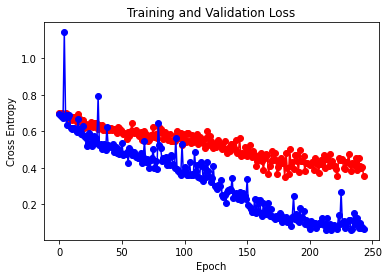

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(loss, 'ro-')
plt.plot(val_loss, 'bo-')
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')
plt.show()

## 모델 저장

In [17]:
model.save('model/inception_model.h5')